Columns in dataset:
 ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_%3B', 'char_freq_%28', 'char_freq_%5B', 'char_freq_%21', 'char_fr

C:\Users\Kavi\AppData\Local\Temp\ipykernel_25520\2276070031.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


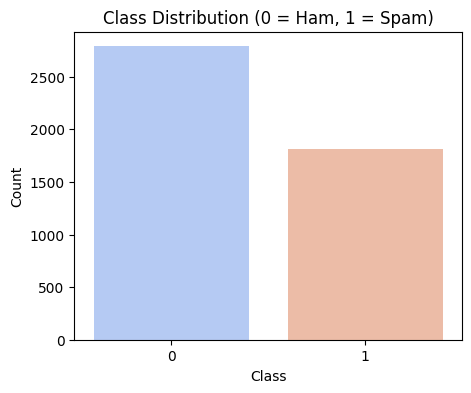

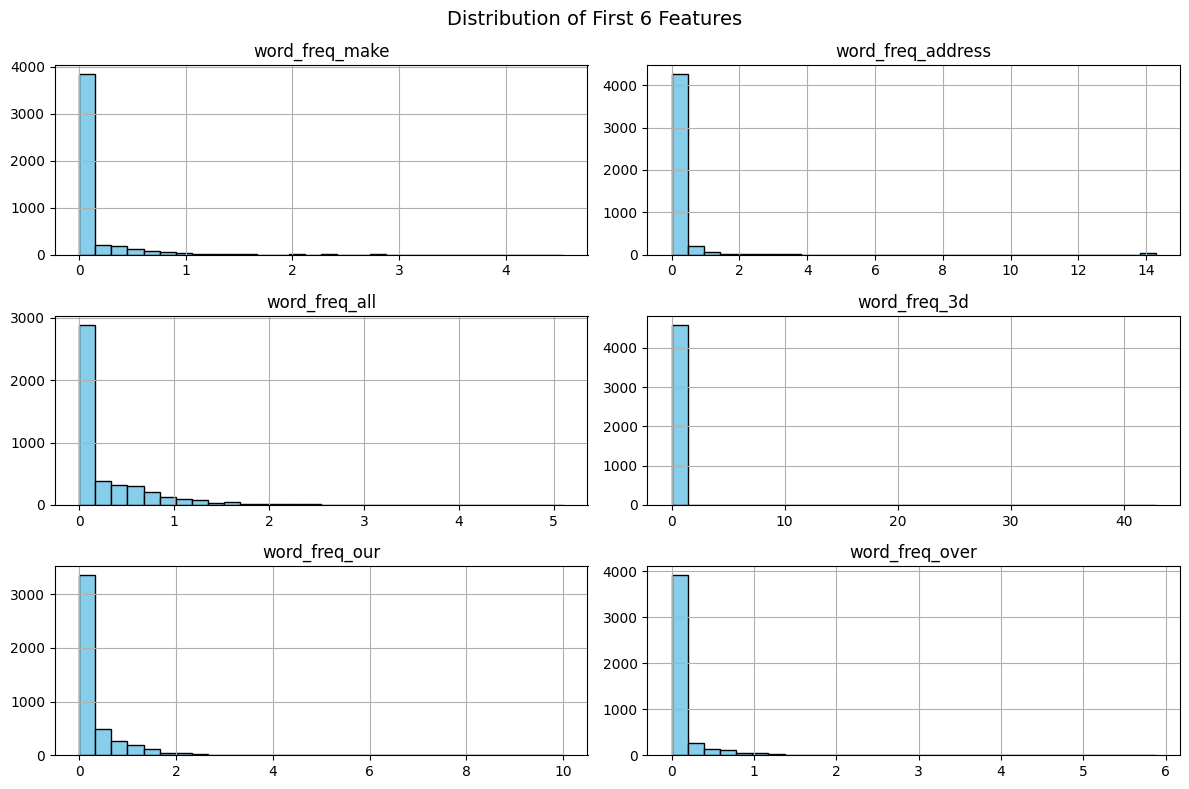

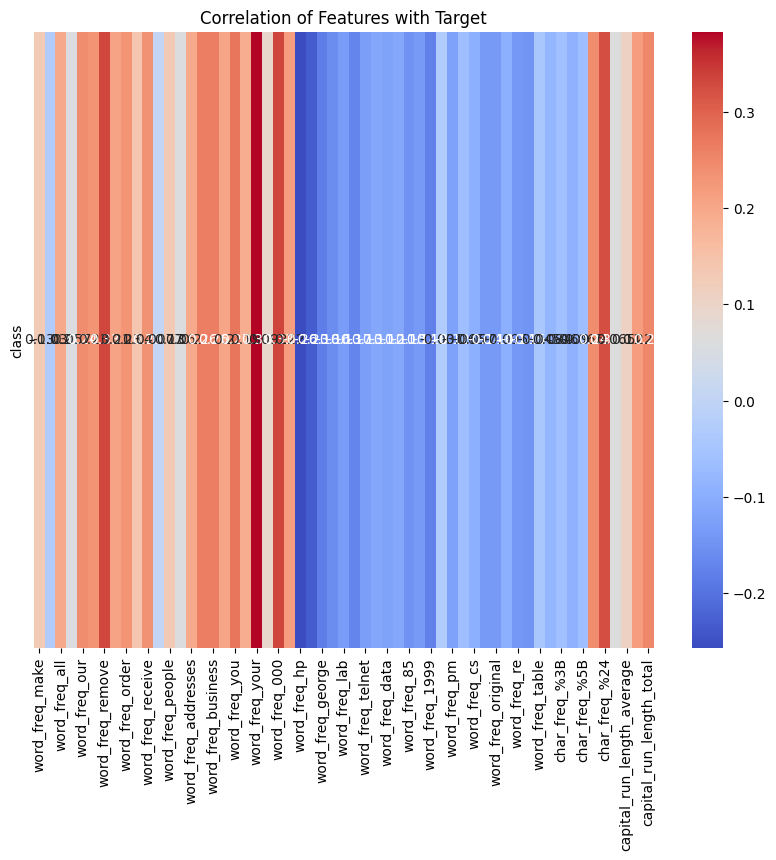

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from joblib import parallel_backend
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, average_precision_score,
    confusion_matrix, classification_report
)

# 1. Load Dataset
df = pd.read_csv('C:/Users/KAVI/Downloads/spambase_csv.csv')
print("Columns in dataset:\n", df.columns.tolist())
print("Dataset shape:", df.shape)

# Statistical summary
df.describe()

# Separate features and target, last column is the target
X = df.drop('class', axis=1)
y = df['class']


# EDA
plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Class Distribution (0 = Ham, 1 = Spam)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Histograms of first 6 features
X.iloc[:, :6].hist(bins=30, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of First 6 Features", fontsize=14)
plt.tight_layout()
plt.show()

# Correlation heatmap (optional, heavy if many features)
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr.iloc[-1:,:-1], annot=True, cmap="coolwarm")
plt.title("Correlation of Features with Target")
plt.show()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [2]:
# Predict & Performance Analysis
from sklearn.inspection import permutation_importance


def test_model(best_estimator, X_test,y_test):
    y_pred = best_estimator.predict(X_test)
    y_proba = best_estimator.predict_proba(X_test)[:, 1]
    return performance_metrics(y_test, y_pred, y_proba)

# Performance metrics
def performance_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    print("\nTest metrics")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Avg Precision (PR AUC-ish): {avg_precision:.4f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # 7. Curves: ROC & Precision-Recall
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--', alpha=0.5)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(); plt.show()

# Define multiple metrics
def kfoldCV(best_estimator, X, y, cv):
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    # Run cross-validation
    with parallel_backend('threading'):
        cv_results = cross_validate(
            best_estimator, X, y, cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )

    n_splits = cv.get_n_splits()
    # Display per-fold results
    for i in range(n_splits):
        print(f"\nFold {i+1}: Accuracy: {cv_results['test_accuracy'][i]:.4f}   Precision: {cv_results['test_precision'][i]:.4f}   Recall: {cv_results['test_recall'][i]:.4f}   F1 Score: {cv_results['test_f1'][i]:.4f}")

    # Display averages
    print("\n=== Average Metrics ===")
    print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
    print(f"Mean Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
    print(f"Mean Recall:    {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
    print(f"Mean F1 Score:  {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................clf__C=0.1, clf__gamma=0.1; total time=   3.2s
[CV] END ...........................clf__C=0.1, clf__gamma=1; total time=   3.4s
[CV] END ...........................clf__C=0.1, clf__gamma=1; total time=   3.3s
[CV] END ...........................clf__C=0.1, clf__gamma=1; total time=  27.6s
[CV] END ...........................clf__C=0.1, clf__gamma=1; total time=   4.2s
[CV] END .........................clf__C=1, clf__gamma=0.001; total time=   6.5s
[CV] END ........................clf__C=0.1, clf__gamma=0.01; total time=  50.0s
[CV] END .........................clf__C=1, clf__gamma=0.001; total time=   1.5s
[CV] END .........................clf__C=1, clf__gamma=0.001; total time=   1.5s
[CV] END ........................clf__C=0.1, clf__gamma=0.01; total time=  52.4s
[CV] END ........................clf__C=0.1, clf__gamma=0.01; total time=  52.7s
[CV] END .......................clf__C=0.1, clf_

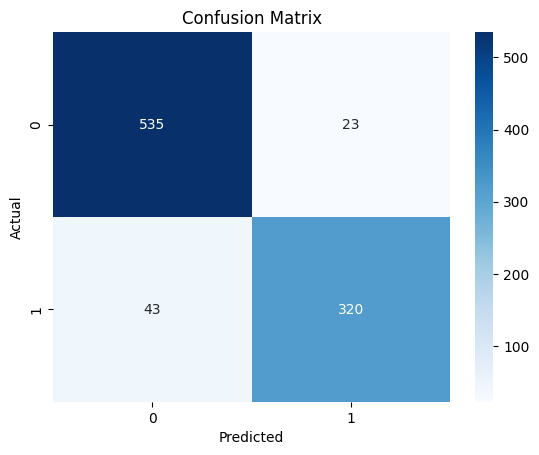

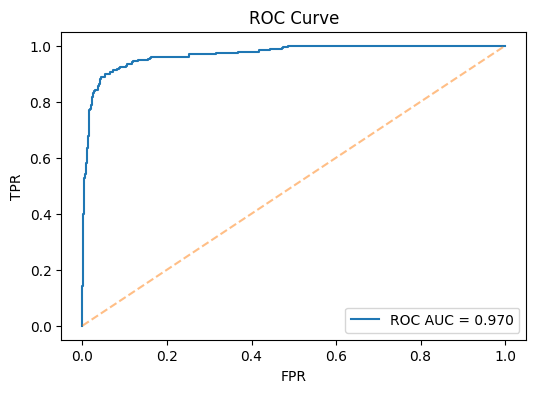


Fold 1: Accuracy: 0.9370   Precision: 0.9296   Recall: 0.9091   F1 Score: 0.9192

Fold 2: Accuracy: 0.9359   Precision: 0.9222   Recall: 0.9146   F1 Score: 0.9184

Fold 3: Accuracy: 0.9413   Precision: 0.9328   Recall: 0.9174   F1 Score: 0.9250

Fold 4: Accuracy: 0.9391   Precision: 0.9347   Recall: 0.9088   F1 Score: 0.9216

Fold 5: Accuracy: 0.9359   Precision: 0.9443   Recall: 0.8895   F1 Score: 0.9161

=== Average Metrics ===
Mean Accuracy: 0.9378 ± 0.0021
Mean Precision: 0.9327 ± 0.0072
Mean Recall:    0.9079 ± 0.0097
Mean F1 Score:  0.9201 ± 0.0030


In [3]:
# SVM with RBF kernel
base_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True))
])

param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': [0.001, 0.01, 0.1, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="f1",   # spam detection: balance precision & recall
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit grid
with parallel_backend('threading'):
    grid.fit(X_train, y_train)
print("\nBest Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# Test the decision tree model
best_estimator = grid.best_estimator_
test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__C=1, clf__coef0=0, clf__degree=2, clf__gamma=scale; total time=   2.0s
[CV] END clf__C=1, clf__coef0=0, clf__degree=2, clf__gamma=scale; total time=   2.0s
[CV] END clf__C=1, clf__coef0=0, clf__degree=2, clf__gamma=0.01; total time=   2.1s
[CV] END clf__C=1, clf__coef0=0, clf__degree=2, clf__gamma=scale; total time=   2.2s
[CV] END clf__C=1, clf__coef0=0, clf__degree=3, clf__gamma=scale; total time=   2.2s
[CV] END clf__C=1, clf__coef0=0, clf__degree=2, clf__gamma=0.01; total time=   2.2s
[CV] END clf__C=1, clf__coef0=0, clf__degree=2, clf__gamma=0.01; total time=   2.2s
[CV] END clf__C=1, clf__coef0=0, clf__degree=2, clf__gamma=0.01; total time=   2.2s
[CV] END clf__C=1, clf__coef0=0, clf__degree=3, clf__gamma=scale; total time=   2.2s
[CV] END clf__C=1, clf__coef0=0, clf__degree=3, clf__gamma=scale; total time=   2.3s
[CV] END clf__C=1, clf__coef0=0, clf__degree=2, clf__gamma=scale; total time=   2.3s
[CV] EN

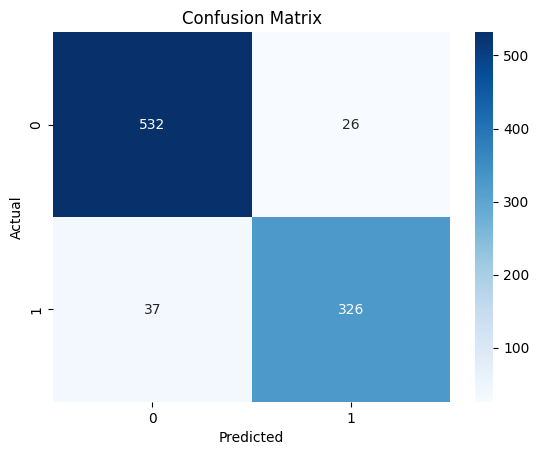

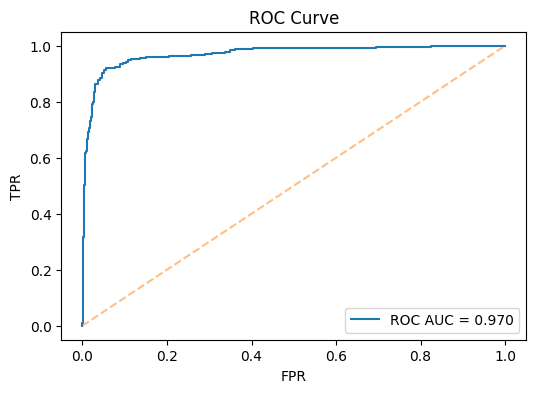


Fold 1: Accuracy: 0.9305   Precision: 0.9164   Recall: 0.9063   F1 Score: 0.9114

Fold 2: Accuracy: 0.9370   Precision: 0.9248   Recall: 0.9146   F1 Score: 0.9197

Fold 3: Accuracy: 0.9359   Precision: 0.9246   Recall: 0.9118   F1 Score: 0.9182

Fold 4: Accuracy: 0.9326   Precision: 0.9310   Recall: 0.8950   F1 Score: 0.9127

Fold 5: Accuracy: 0.9359   Precision: 0.9341   Recall: 0.9006   F1 Score: 0.9170

=== Average Metrics ===
Mean Accuracy: 0.9344 ± 0.0024
Mean Precision: 0.9262 ± 0.0061
Mean Recall:    0.9057 ± 0.0072
Mean F1 Score:  0.9158 ± 0.0032


In [4]:

# SVM with Polynomial kernel
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='poly', probability=True))
])

# 4. Hyperparameter grid for polynomial kernel
param_grid = {
    'clf__C': [1, 10],
    'clf__gamma': ['scale', 0.01],
    'clf__degree': [2, 3],
    'clf__coef0': [0, 1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",   # spam detection: balance precision & recall
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit grid
with parallel_backend('threading'):
    grid.fit(X_train, y_train)
print("\nBest Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# Test the decision tree model
best_estimator = grid.best_estimator_
test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...........svc__C=0.1, svc__coef0=0, svc__gamma=0.1; total time=   1.4s
[CV] END ...........svc__C=0.1, svc__coef0=0, svc__gamma=0.1; total time=   1.4s
[CV] END ...........svc__C=0.1, svc__coef0=0, svc__gamma=0.1; total time=   1.4s
[CV] END ...........svc__C=0.1, svc__coef0=0, svc__gamma=0.1; total time=   1.5s
[CV] END ..........svc__C=0.1, svc__coef0=-1, svc__gamma=0.1; total time=   1.7s
[CV] END ...........svc__C=0.1, svc__coef0=0, svc__gamma=0.1; total time=   1.7s
[CV] END ..........svc__C=0.1, svc__coef0=-1, svc__gamma=0.1; total time=   1.8s
[CV] END ..........svc__C=0.1, svc__coef0=-1, svc__gamma=0.1; total time=   1.8s
[CV] END ..........svc__C=0.1, svc__coef0=-1, svc__gamma=0.1; total time=   1.9s
[CV] END ..........svc__C=0.1, svc__coef0=-1, svc__gamma=0.1; total time=   1.9s
[CV] END .........svc__C=0.1, svc__coef0=-1, svc__gamma=0.01; total time=   2.7s
[CV] END ..........svc__C=0.1, svc__coef0=0, svc

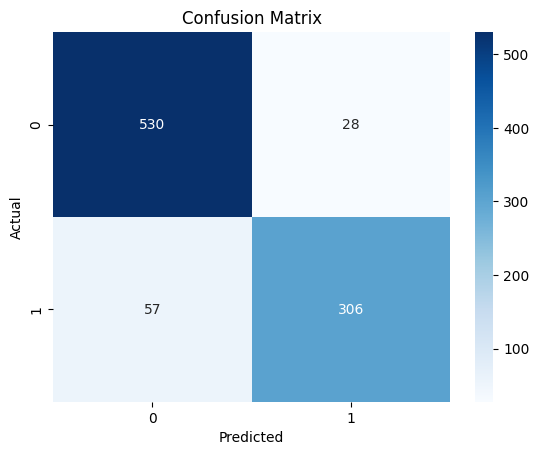

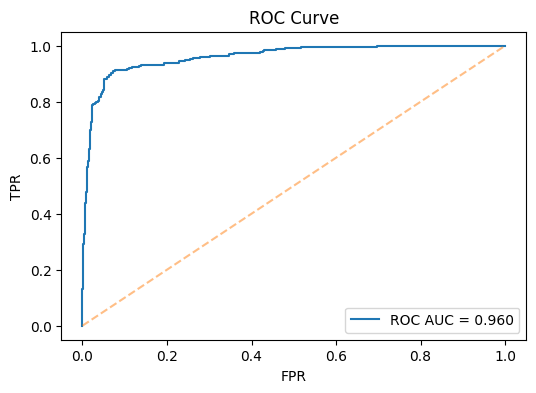


Fold 1: Accuracy: 0.9175   Precision: 0.9362   Recall: 0.8485   F1 Score: 0.8902

Fold 2: Accuracy: 0.9120   Precision: 0.9147   Recall: 0.8567   F1 Score: 0.8848

Fold 3: Accuracy: 0.9272   Precision: 0.9229   Recall: 0.8898   F1 Score: 0.9060

Fold 4: Accuracy: 0.9152   Precision: 0.9251   Recall: 0.8536   F1 Score: 0.8879

Fold 5: Accuracy: 0.9098   Precision: 0.9373   Recall: 0.8260   F1 Score: 0.8781

=== Average Metrics ===
Mean Accuracy: 0.9163 ± 0.0060
Mean Precision: 0.9272 ± 0.0085
Mean Recall:    0.8549 ± 0.0205
Mean F1 Score:  0.8894 ± 0.0093


In [5]:
# SVM with Sigmoid kernel
base_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel='sigmoid', probability=True))
])

# Sigmoid is sensitive — keep search ranges reasonable
param_grid = {
    "svc__C": [0.1, 1, 10],
    "svc__gamma": [0.1, 0.01],
    "svc__coef0": [-1, 0, 1]  # coef0 affects curve shift
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="f1",   # spam detection: balance precision & recall
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit grid
with parallel_backend('threading'):
    grid.fit(X_train, y_train)
print("\nBest Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# Test the decision tree model
best_estimator = grid.best_estimator_
test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .................clf__C=0.1, clf__class_weight=None; total time=   0.1s
[CV] END ............clf__C=0.01, clf__class_weight=balanced; total time=   0.1s
[CV] END .............clf__C=0.1, clf__class_weight=balanced; total time=   0.1s
[CV] END .................clf__C=0.1, clf__class_weight=None; total time=   0.1s
[CV] END ................clf__C=0.01, clf__class_weight=None; total time=   0.1s
[CV] END .................clf__C=0.1, clf__class_weight=None; total time=   0.1s
[CV] END ................clf__C=0.01, clf__class_weight=None; total time=   0.1s
[CV] END ................clf__C=0.01, clf__class_weight=None; total time=   0.1s
[CV] END ............clf__C=0.01, clf__class_weight=balanced; total time=   0.1s
[CV] END .................clf__C=0.1, clf__class_weight=None; total time=   0.1s
[CV] END .................clf__C=0.1, clf__class_weight=None; total time=   0.1s
[CV] END ................clf__C=0.01, clf__class

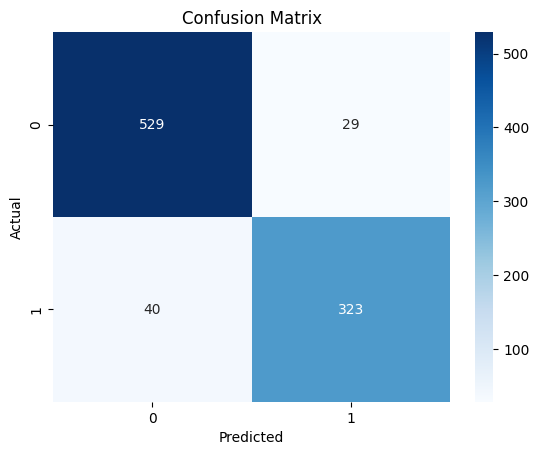

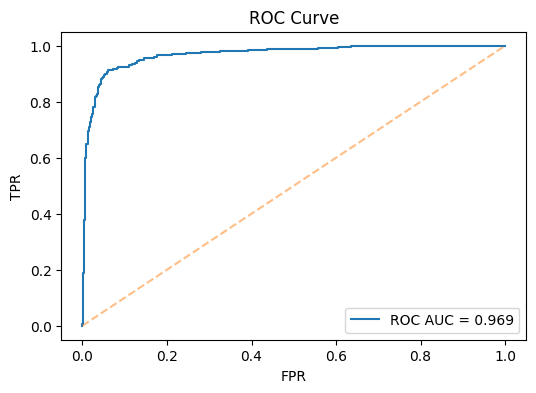


Fold 1: Accuracy: 0.9175   Precision: 0.9362   Recall: 0.8485   F1 Score: 0.8902

Fold 2: Accuracy: 0.9120   Precision: 0.9147   Recall: 0.8567   F1 Score: 0.8848

Fold 3: Accuracy: 0.9272   Precision: 0.9229   Recall: 0.8898   F1 Score: 0.9060

Fold 4: Accuracy: 0.9152   Precision: 0.9251   Recall: 0.8536   F1 Score: 0.8879

Fold 5: Accuracy: 0.9098   Precision: 0.9373   Recall: 0.8260   F1 Score: 0.8781

=== Average Metrics ===
Mean Accuracy: 0.9163 ± 0.0060
Mean Precision: 0.9272 ± 0.0085
Mean Recall:    0.8549 ± 0.0205
Mean F1 Score:  0.8894 ± 0.0093


In [6]:
# Linear SVM (LinearSVC)
from sklearn.calibration import LinearSVC
base_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(dual=False, max_iter=5000, random_state=42))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="f1",          # for spam detection, F1 is more informative
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit grid
with parallel_backend('threading'):
    grid.fit(X_train, y_train)
print("\nBest Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# Use the best linear SVC but calibrated for probabilities
best_linear_svc = grid.best_estimator_.named_steps['clf']
# recreate a pipeline with scaler + calibrated classifier
pipe_scaler = Pipeline([("scaler", grid.best_estimator_.named_steps['scaler'])])  # same scaler
X_train_scaled = pipe_scaler.transform(X_train)
X_test_scaled = pipe_scaler.transform(X_test)

calibrated = CalibratedClassifierCV(estimator=best_linear_svc, cv=cv)
calibrated.fit(X_train_scaled, y_train)   # base_estimator already trained internally by grid but safe to fit
test_model(calibrated, X_test_scaled, y_test)
kfoldCV(best_estimator, X, y, cv)
